## **Programa de Pós-Graduação em Computação - INF/UFRGS**
### Disciplina CMP263 - Aprendizagem de Máquina
#### *Profa. Mariana Recamonde-Mendoza (mrmendoza@inf.ufrgs.br)*
<br>

---
***Observação:*** *Este notebook é disponibilizado aos alunos como complemento às aulas síncronas e aos slides preparados pela professora. Desta forma, os principais conceitos são apresentados no material teórico fornecido. *


---

<br>

## **Tópico: Overfitting e Underfitting no Treinamento de Modelos Preditivos**

<br>


Este notebook é baseado no Tutorial: https://thedatafrog.com/en/articles/overfitting-illustrated/


<br>

**Objetivo deste notebook**: Compreender os conceitos de overfitting e underfitting, com exemplos práticos.
<br>

---



Imports e configurações iniciais:


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
np.random.seed(0xdeadbeef)

## Dataset Fictício

Vamos criar uma amostra de exemplos com dois atributos x1 e x2, e duas classes. Para a classe 0, a distribuição de probabilidade subjacente é uma Gaussiana 2D centrada em (0,0), com largura = 1 ao longo de ambas as direções. Para a classe 1, a Gaussiana é centrada em (1,1).

In [ ]:
def make_sample(nexamples, means=([0.,0.],[1.,1.]), sigma=1.):
    normal = np.random.multivariate_normal
    # squared width:
    s2 = sigma**2.
    # below, we provide the coordinates of the mean as
    # a first argument, and then the covariance matrix
    # which describes the width of the Gaussian along the
    # two directions.
    # we generate nexamples examples for each category
    sgx0 = normal(means[0], [[s2, 0.], [0.,s2]], nexamples)
    sgx1 = normal(means[1], [[s2, 0.], [0.,s2]], nexamples)
    # setting the labels for each category
    sgy0 = np.zeros((nexamples,))
    sgy1 = np.ones((nexamples,))
    sgx = np.concatenate([sgx0,sgx1])
    sgy = np.concatenate([sgy0,sgy1])
    return sgx, sgy

Aqui, criamos uma amostra de treinamento  (sgx, sgy)  muito pequena com apenas 30 exemplos por classe, e uma amostra de teste (tgx, tgy) com 200 exemplos por classe. Estamos usando uma amostra de treinamento pequena pra mostrar que poucos dados favorecem overfitting.

In [ ]:
sgx, sgy = make_sample(30)
tgx, tgy = make_sample(200)

Text(0, 0.5, 'x2')

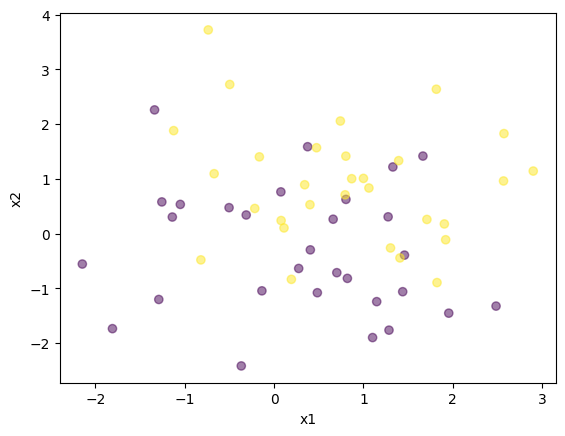

In [ ]:
# plot do dataset pequeno, as cores são de acordo com a classe
plt.scatter(sgx[:,0], sgx[:,1], alpha=0.5, c=sgy)
plt.xlabel('x1')
plt.ylabel('x2')

Vemos que com um número tão baixo de exemplos, não é óbvio que as amostras seguem funções de densidade de probabilidade gaussianas. Além disso, como as gaussianas são tão próximas, será bem difícil separar as duas categorias.



## Overfitting

Vamos tentar classificar os dados com uma rede neural "complexa", de forma proposital para ilustrar o overfitting. Ela é construida na célula abaixo, com as características (pode ser customizado):

*   3 camadas ocultas de 50 neurônios cada,
*   Ativação ReLU, pois a Função ReLU torna o treinamento mais fácil em redes neurais com camadas ocultas,
* Otimizador Adam, variação sofisticada da descida de gradiente,
* um número máximo elevado de iterações, para que a rede tenha tempo para convergir,
* uma semente aleatória fixa para que você possa obter exatamente os mesmos resultados que eu, toda vez que executar o código


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

def get_scikit_mlp(data_x, data_y):
  mlp = MLPClassifier(hidden_layer_sizes=(50,50,50), activation='relu', max_iter=10000, random_state=1)
  mlp.fit(data_x, data_y)
  return mlp


Agora vamos definir uma pequena função para plotar nossos resultados. A função plotará os exemplos nas duas classes, bem como a probabilidade de que um ponto (x1,x2) pertença à classe 1 (preto significa que essa probabilidade está próxima de 1, e branco, de 0). Não se preocupe com esse código, apenas que ele recebe a rede treinada e os dados para mostrar.

In [ ]:
def plot_result_scikit(model, data_x, data_y, linrange=(-5,5,101)):
    xmin, xmax, npoints = linrange
    gridx1, gridx2 = np.meshgrid(np.linspace(xmin,xmax,npoints), np.linspace(xmin,xmax,npoints))
    grid = np.c_[gridx1.flatten(), gridx2.flatten()]

    probs = model.predict_proba(grid)

    accuracy = accuracy_score(data_y, model.predict(data_x))
    print(f"Accuracy: {accuracy:.5f}")

    #print(probs)
    plt.pcolor(gridx1, gridx2, probs[:,1].reshape(npoints,npoints), cmap='binary')
    plt.colorbar()
    plt.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap='plasma', alpha=0.5, marker='.')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()


Accuracy: 1.00000


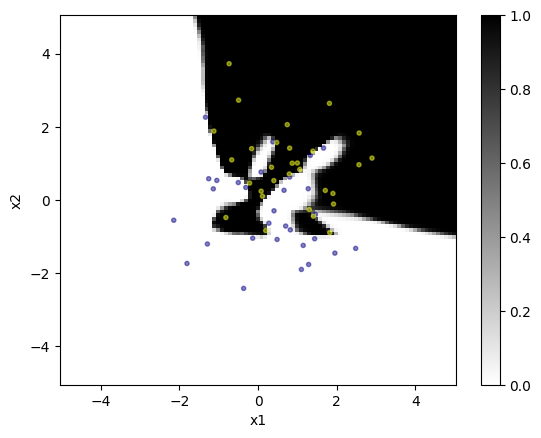

In [ ]:
scikit_model = get_scikit_mlp(sgx, sgy)
plot_result_scikit(scikit_model, sgx,sgy)

Vemos que na fronteira, a rede neural faz o melhor que pode para seguir os padrões da amostra de treinamento -- Os pontos estão bem ajustados pela superfície de decisão. Ela é capaz de fazer isso porque seu grande número de parâmetros a torna muito flexível e adaptável. Porém, ela está longe de capturar a distribuição dos pontos (as gaussianas). Vamos ver o que acontece se plotarmos a distribuição de probabilidade com a amostra de teste maior.


Accuracy: 0.63750


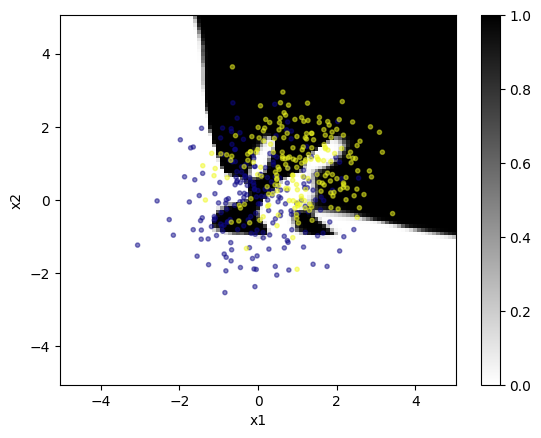

In [ ]:
plot_result_scikit(scikit_model, tgx,tgy)

Um monte de exemplos foram mal classificados. A rede foi muito bem no treino, e mal no teste.

**Isso é overfitting.**

## Testando uma rede menor

Agora vamos tentar novamente, mas com uma rede muito mais simples, com uma única camada com cinco neurônios. A rede é treinada com a pequena amostra de treinamento e exibida com a amostra de teste maior.


In [ ]:
def get_smaller_scikit_mlp(data_x, data_y):
  mlp = MLPClassifier(hidden_layer_sizes=(5,), activation='relu', max_iter=10000, random_state=1)
  mlp.fit(data_x, data_y)
  return mlp


Accuracy: 0.72000


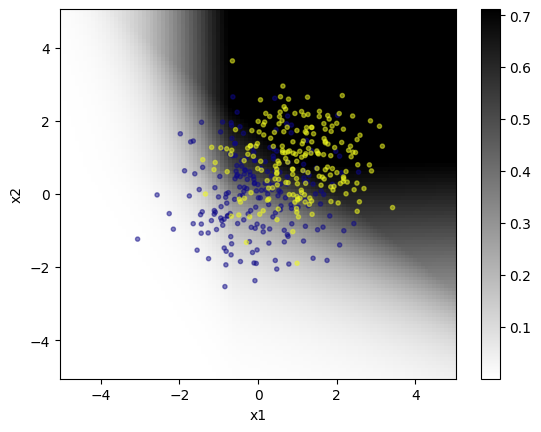

In [ ]:
scikit_model = get_smaller_scikit_mlp(sgx, sgy)
plot_result_scikit(scikit_model, tgx, tgy)


Desta vez, o overfitting é um problema muito menor. A rede não tem parâmetros suficientes para conseguir seguir os padrões aleatórios da amostra de treinamento. Portanto, ela se comporta muito bem na amostra de teste.

Vamos tentar outra coisa. Desta vez, usamos a rede complexa, mas fornecemos muito mais dados de treinamento: 10.000 exemplos por classe em vez de 30.

Accuracy: 0.75000


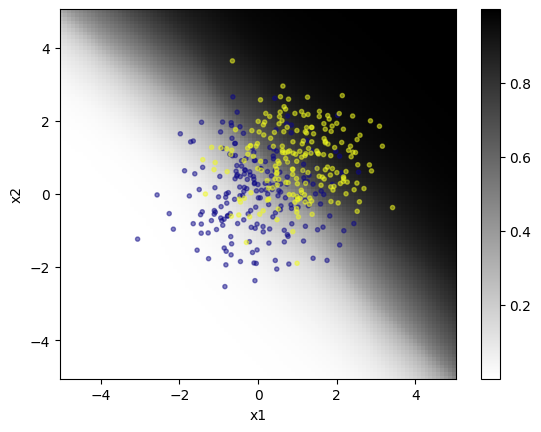

In [ ]:
sgx, sgy = make_sample(10000)
scikit_model = get_scikit_mlp(sgx, sgy)
#plot_result_scikit(scikit_model, sgx,sgy)
plot_result_scikit(scikit_model, tgx,tgy)

Agora, a rede não tem parâmetros suficientes pra seguir as aleatoriedades do conjunto de treinamento, e tenta encontrar um padrão geral.


## Redes complexas para dados complexos

Vamos construir um dataset complexo com 8 "montanhas" Gaussianas de dados, cada uma centrada em uma coordenada do espaço.

Cada chamada a make_sample cria 2 montanhas, uma pra cada classe, de acordo com as coordenadas especificadas.

In [ ]:
sgxa, sgya = make_sample(100, ([0.,0],[1.,1.]), 0.3)
sgxb, sgyb = make_sample(100, ([3.,3],[4.,4.]), 0.3)
sgxc, sgyc = make_sample(100, ([5.,5.],[-2.,-2.]), 0.6)
sgxd, sgyd = make_sample(100, ([-1,3.],[3.,-1.]), 0.3)

data_x = np.concatenate([sgxa,sgxb,sgxc,sgxd])
data_y = np.concatenate([sgya,sgyb,sgyc,sgyd])

Text(0, 0.5, 'x2')

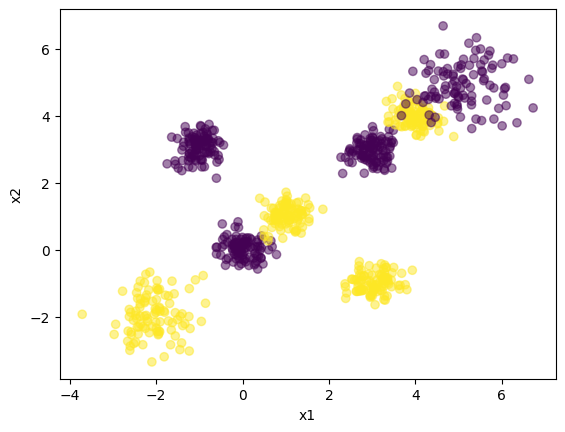

In [ ]:
#plt.scatter(data_x[:,0], data_x[:,1], alpha=0.5, c=sgy)
plt.scatter(data_x[:,0], data_x[:,1], alpha=0.5, c=data_y)
plt.xlabel('x1')
plt.ylabel('x2')

Uma rede pequena poderá classificar esses dados corretamente? Execute e analise o código com uma rede muito simples, com 1 camada oculta de 3 neurônios). (Usamos a chamada do scikit)

Accuracy: 0.74000


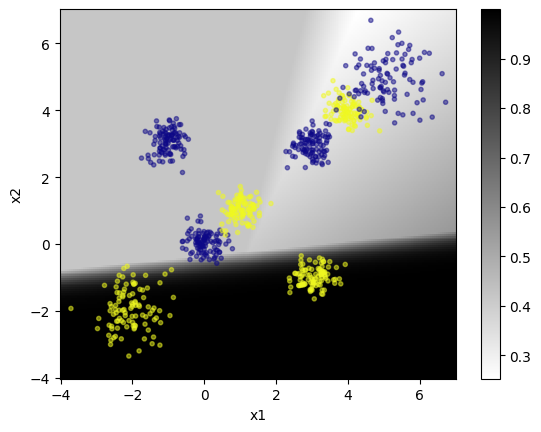

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(3,), activation='relu', max_iter=10000)
mlp.fit(data_x, data_y)
plot_result_scikit(mlp, data_x, data_y,linrange=(-4,7,201))

A rede até faz um trabalho decente, mas não tem parâmetros suficientes para se ajustar aos dados.

**Isso é underfitting.**

A seguir, especificamos um MLPClassifier com 1 camada oculta de 5 neurônios:

Accuracy: 0.49750


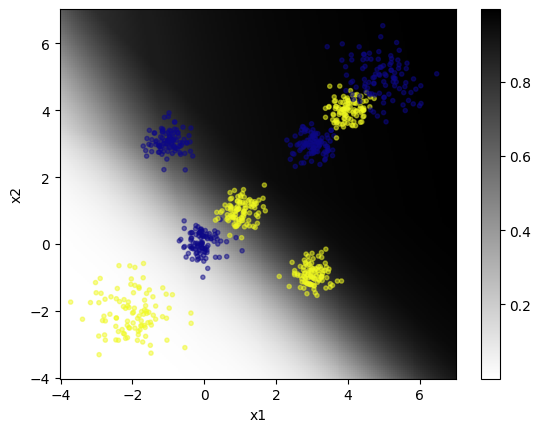

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(5,), activation='relu', max_iter=10000, random_state=1)
mlp.fit(sgx,sgy)
plot_result_scikit(mlp, data_x, data_y,linrange=(-4,7,201))

Vamos dar "poder preditivo" suficiente à rede, colocando 3 camadas ocultas de 50 neurônios cada:

Accuracy: 0.49625


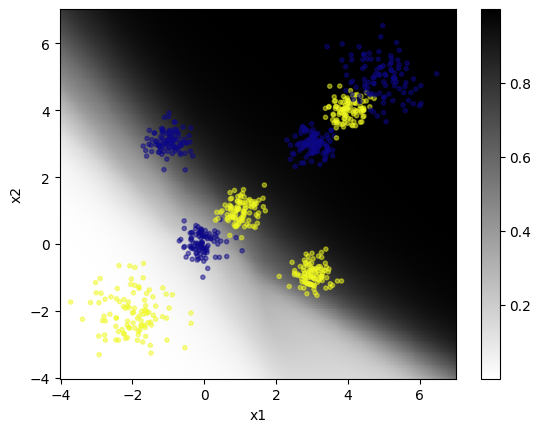

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(50,50,50), activation='relu', max_iter=10000, random_state=1)
mlp.fit(sgx,sgy)
plot_result_scikit(mlp, data_x, data_y,linrange=(-4,7,201))

Ainda sem overfitting. A rede agora mostra uma fronteira de decisão suave, e certamente seria capaz de se adaptar mais, se necessário.